# Resolución

En este ejercicio se emplea un dataset de flores con aproximadamente 700 imágenes por clase con 5 clases (margarita, diente de leon, rosas, girasoles y tulipanes). A diferencia del dataset Iris, este conjunto presenta una gran cantidad de ejemplos y un balance adecuado entre categorías, lo que favorece el proceso de entrenamiento. El objetivo es observar cómo el tamaño y la calidad del dataset impactan en la capacidad del modelo para generalizar correctamente.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Rescaling, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2025-11-12 10:14:26.245046: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-12 10:14:26.359420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-12 10:14:29.213531: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# Rutas
data_dir = "./Datasets/flower_photos"
csv_path = os.path.join(data_dir, "all_labels.csv")
img_dir = os.path.join(data_dir, "flowers")

# Leer el CSV
df = pd.read_csv(csv_path)

# Convertimos los textos de las clases a números (0,1,2)
class_names = sorted(df["label"].unique())
class_to_index = {name: i for i, name in enumerate(class_names)}
df["label"] = df["label"].map(class_to_index)


print("Clases detectadas:", class_to_index)

Clases detectadas: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [3]:
# Dividir en entrenamiento (80%) y validación (20%)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Función para cargar una imagen desde su ruta y etiqueta
def load_image(image_name, label):
    img_path = tf.strings.join([img_dir, "/", image_name])
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    return img, label

In [4]:
# Crear datasets de TensorFlow

# Convierte las columnas (file_name y label) del dataset en un objeto tf.data.Dataset para entrenar de forma eficiente
train_ds = tf.data.Dataset.from_tensor_slices((train_df["file_name"].values, train_df["label"].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df["file_name"].values, val_df["label"].values))

# Mapear la función de carga de imágenes a los datasets
train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

2025-11-12 10:14:31.325692: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# Normalización y aumento
normalization_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

# Aplicar aumento y normalización
train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x)), y),
                        num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

# Configurar rendimiento
train_ds = train_ds.shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [6]:
# Modelo convolucional
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Conv2D(128, (3,3), activation='relu'),
    # MaxPooling2D(2,2),
    
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')  # número de clases automático
])

/home/juancho_gonzalez/Escritorio/Inteligencia artificial/Practicos-IA/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Compilación
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=[early_stop]
)

Epoch 1/60
91/91 ━━━━━━━━━━━━━━━━━━━━ 63s 652ms/step - accuracy: 0.4776 - loss: 1.2723 - val_accuracy: 0.3867 - val_loss: 1.3629
Epoch 2/60
91/91 ━━━━━━━━━━━━━━━━━━━━ 58s 625ms/step - accuracy: 0.5532 - loss: 1.1119 - val_accuracy: 0.5331 - val_loss: 1.1408
Epoch 3/60
91/91 ━━━━━━━━━━━━━━━━━━━━ 60s 643ms/step - accuracy: 0.5908 - loss: 1.0386 - val_accuracy: 0.5939 - val_loss: 1.0789
Epoch 4/60
91/91 ━━━━━━━━━━━━━━━━━━━━ 59s 638ms/step - accuracy: 0.6112 - loss: 1.0089 - val_accuracy: 0.5870 - val_loss: 1.0072
Epoch 5/60
91/91 ━━━━━━━━━━━━━━━━━━━━ 58s 623ms/step - accuracy: 0.6236 - loss: 0.9640 - val_accuracy: 0.5925 - val_loss: 0.9893
Epoch 6/60
91/91 ━━━━━━━━━━━━━━━━━━━━ 57s 617ms/step - accuracy: 0.6478 - loss: 0.9315 - val_accuracy: 0.4669 - val_loss: 1.2754
Epoch 7/60
91/91 ━━━━━━━━━━━━━━━━━━━━ 58s 623ms/step - accuracy: 0.6640 - loss: 0.8850 - val_accuracy: 0.6506 - val_loss: 0.8956
Epoch 8/60
91/91 ━━━━━━━━━━━━━━━━━━━━ 58s 628ms/step - accuracy: 0.6588 - loss: 0.8691 - val_accu

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7624 - loss: 0.6302

🔹 Resultados finales:
Pérdida (loss): 0.6302
Precisión (accuracy): 0.7624


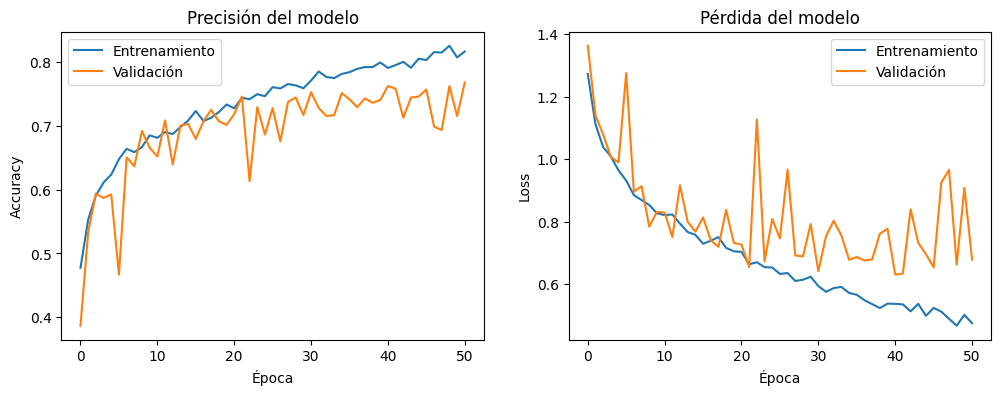

In [8]:
# Evaluación
results = model.evaluate(val_ds)
print("\n🔹 Resultados finales:")
print(f"Pérdida (loss): {results[0]:.4f}")
print(f"Precisión (accuracy): {results[1]:.4f}")

# Gráficos
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


2025-11-12 11:05:07.579196: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


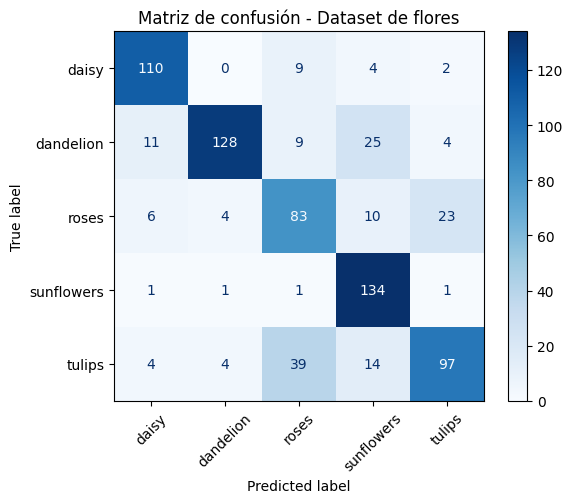

In [12]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Matriz de confusion para ver cuanto acierta comparando las clases
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de confusión - Dataset de flores")
plt.show()

# Conclusión

El modelo alcanzó un accuracy en validación cercano a 0.8. Con esto, podemos observar una mejora notable respecto a los experimentos con el dataset Iris. Este incremento de rendimiento se debe principalmente a la mayor cantidad de datos por clase y a la distribución equilibrada del conjunto, que permiten que la red aprenda patrones visuales más estables y representativos. En síntesis, este resultado confirma que la cantidad y el balance de datos son factores determinantes para el éxito del aprendizaje automático: un dataset amplio y bien distribuido mejora significativamente la precisión y reduce el sesgo del modelo.